# Qiskit Machine Learning v0.5 Migration Guide

This tutorial will guide you through the process of migrating your code from Qiskit Machine Learning v0.4 to v0.5.

## Introduction

The main focus of the 0.5 release of Qiskit Machine Learning is the migration of the base computational blocks like quantum kernels and quantum neural networks to the primitives introduced in Qiskit as well as extended support of the primitives in the algorithms.

Contents:

- Overview of the primitives
- New quantum kernel
- New quantum neural networks
- Other notable deprecation


## Overview of the primitives

The core capability of quantum computers that sets them apart from from classical computers is their ability to generate non-classical probability distributions at their outputs. The native operations that one can do with a probability distribution is to sample from it or to estimate quantities on it. Consequently, these operations of sampling and estimating form the fundamental building blocks of quantum algorithm development. Thus, as it was [announced](https://research.ibm.com/blog/qiskit-runtime-for-useful-quantum-computing), two basic primitives were introduced, Sampler and Estimator, respectively, that implement these two operations:

- Sampler class calculates probabilities or quasi-probabilities of bitstrings from quantum circuits. The base class is [qiskit.primitives.BaseSampler](https://qiskit.org/documentation/stubs/qiskit.primitives.BaseSampler.html).
- Estimator class estimates expectation values of quantum circuits and observables. The base class is [qiskit.primitives.BaseEstimator](https://qiskit.org/documentation/stubs/qiskit.primitives.BaseEstimator.html).

Qiskit Terra provides core interfaces and two implementations:

- The reference implementation that is statevector based. This implementation does require a backend or a simulator, it relies on the classes from the [quantum_info](https://qiskit.org/documentation/apidoc/quantum_info.html) package.
- The backend based primitives are to support provider/backends that do not support primitives directly. This implementation requires an instance of a backend to be passed to a primitive.

More information on the Qiskit Terra primitives can be found in the [documentation](https://qiskit.org/documentation/apidoc/primitives.html).

It is worth mentioning other implementations as well:

- Aer primitives should be used for Aer simulator. They extend corresponding interfaces from Terra and can be used in the same way as primitives from Terra. See [documentation](https://qiskit.org/documentation/apidoc/aer_primitives.html) for more information.
- The runtime primitives to be used with IBM devices. This is an implementation that is focused on cloud computing on actual hardware. See [here](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/apidocs/runtime_service.html).

Along with the primitives Terra has some primitive-like algorithms that are highly useful in QML and used by the new 0.5 functions:

- Algorithms to calculate the gradient of a quantum circuit. For each core primitive there's a corresponding base interface that defines quantum circuit gradient. The documentation on gradients is [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.gradients.html).
- Algorithms that compute the fidelity or "closeness" of pairs of quantum states. Currently, only one implementation is available that requires a sampler primitive and is based on the compute-uncompute method. The documentation is [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.state_fidelities.html).

Both two new algorithms are very similar to the core primitives, they share the same method signatures, so they may be called as high level primitives despite they are not in the primitives package.

## New quantum kernel

The previous implementation consisted of a single class [QuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html) that did everything:

- Constructed circuits
- Executed circuits and evaluated overlap between circuits
- Provided training parameters
- Kept track of the values assigned to the parameters.

The implementation became sophisticated and inflexible and adding support of the new primitives could be tricky. To address the issues, a new flexible and extendable design of quantum kernels was introduced. The goals of the new design are: 

- Migrate to the primitives and leverage the fidelity algorithm. Now users may plug in their own implementations of fidelity calculations.
- Extract trainability feature to a dedicated class.
- Introduce a base class that can be extended by other kernel implementations.

The new design of quantum kernel is shown on the next diagram.

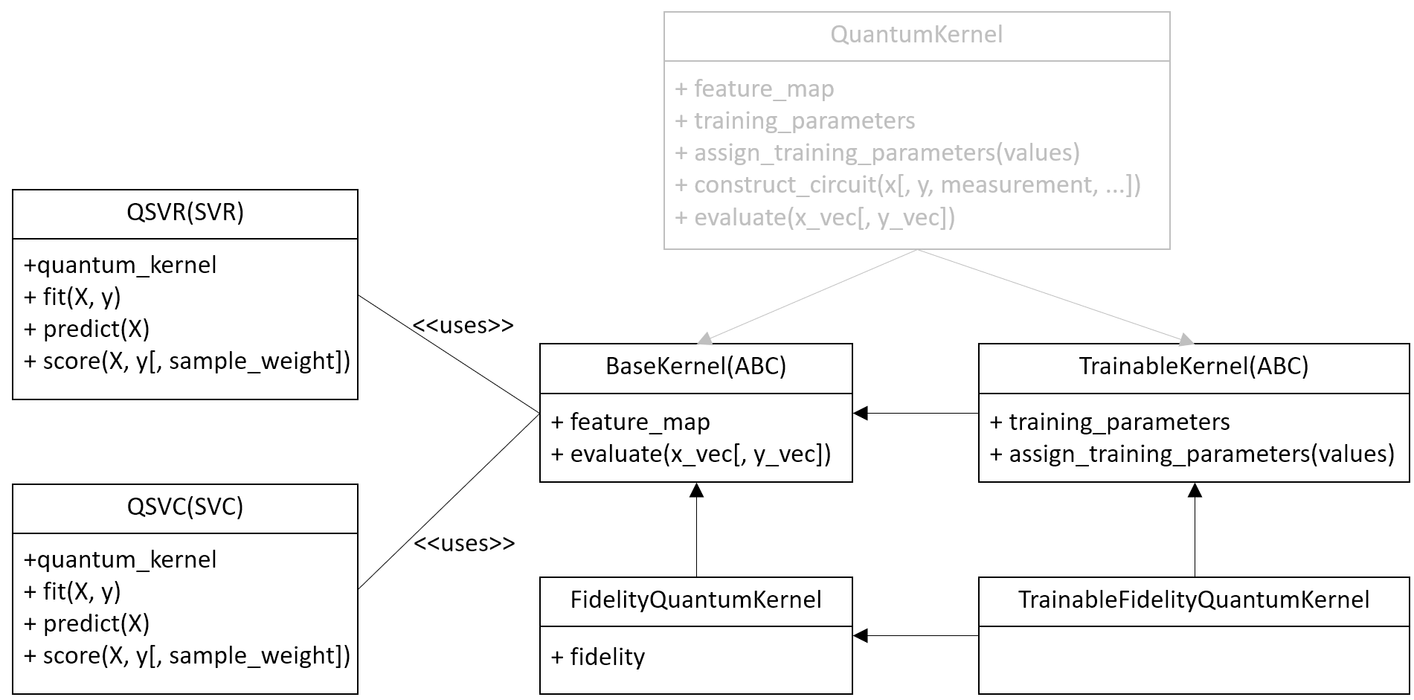

The new kernels expose the same interface and the same parameters except the `quantum_instance` parameter. This parameter does not have a direct replacement and instead the `fidelity` parameter must be used. The backend handling/selection, which was previously done using the `quantum_instance`, is now taken care of via the Sampler primitive given to the `fidelity`.

A new hierarchy shown on the diagram introduces:

 - A base and abstract class [BaseKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.BaseKernel.html) is introduced. All concrete implementation must inherit this class.
 - A fidelity based quantum kernel [FidelityQuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) is added. This is a direct **replacement** of the previous quantum kernel implementation. The difference is that the new class takes a fidelity instance to estimate overlaps and construct kernel matrix.
 - A new abstract class [TrainableKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.TrainableKernel.html) is introduced to generalize ability to train quantum kernels.
 - A fidelity-based trainable quantum kernel [TrainableFidelityQuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.TrainableFidelityQuantumKernel.html) is introduced. This is a **replacement** of the previous quantum kernel if a trainable kernel is required. The trainer [QuantumKernelTrainer](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.alogrithms.QuantumKernelTrainer.html) now accepts both quantum kernel implementations, the new one and the previous one.
 
For convenience, the previous quantum kernel implementation, [QuantumKernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html), now extends both new abstract classes and thus it is compatible with the new introduced interfaces. This implementation is now **pending deprecation**, will be deprecated in a future release and subsequently removed after that. New, primitive-based quantum kernels should be used instead.

The existing algorithms such as [QSVC](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html), [QSVR](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QSVR.html) and other kernel-based algorithms are updated and work with both implementations.

For example a QSVM classifier can be trained as follows.

## Create a dataset


Fixing randomization.

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123456

Generate a simple dataset using scikit-learn.

In [2]:
from sklearn.datasets import make_blobs

features, labels = make_blobs(
    n_samples=20,
    centers=2,
    center_box=(-1, 1),
    cluster_std=0.1,
    random_state=algorithm_globals.random_seed,
)

### Previous implementation of quantum kernel

In the previous implementation we start from creating an instance of `QuantumInstance`. This class defines where our quantum circuits are executed. In this case we wrap a statevector simulator in the quantum instance.

In [3]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

sv_qi = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

Then create a quantum kernel.

In [4]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

feature_map = ZZFeatureMap(2)
previous_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=sv_qi)

And finally we fit an SVM classifier.

In [5]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=previous_kernel)
qsvc.fit(features, labels)
qsvc.score(features, labels)

0.95

### New implementation of quantum kernel

In the new implementation we start from creating a Fidelity instance. Fidelity is optional and quantum kernel will create it automatically if none is passed. But here, we create it manually for illustrative purposes. To create a fidelity instance we pass a sampler. The sampler is the reference implementation and defines where our quantum circuits are executed. You may create a sampler instance from [QiskitRuntimeService](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html) to leverage Qiskit runtime services.

In [6]:
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler

fidelity = ComputeUncompute(sampler=Sampler())

Next, we create a new quantum kernel with the fidelity instance.

In [7]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(2)
new_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

Then we fit an SVM classifier the same way as before.

In [8]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=new_kernel)
qsvc.fit(features, labels)
qsvc.score(features, labels)

0.95

## New quantum neural networks

Changes in the quantum neural networks are not as dramatic as in quantum kernels. In addition, and as a replacement to the existing neural networks, two new networks are introduced. The new networks introduced are [SamplerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html) and [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) which are detailed below and are replacements for the pre-existing [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html), [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html) and [TwoLayerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.TwoLayerQNN.html) which are now pending deprecated.

### SamplerQNN

A new [Sampler Quantum Neural Network](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html) leverages the sampler primitive, sampler gradients and is a **direct replacement** of [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html).

The new [SamplerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html) exposes a similar interface to the existing [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html), with a
few differences. One is the `quantum_instance` parameter. This parameter does not have a direct replacement, and instead the `sampler` parameter must be used. The `gradient` parameter keeps the same name as in the [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html) implementation, but it no longer accepts Opflow gradient classes as inputs; instead, this parameter expects an (optionally custom) primitive gradient. The `sampling` option has been removed for the time being, as this information is not currently exposed by the sampler, and might correspond to future lower-level primitives.

The existing training algorithms such as [VQC](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) that were based on [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html), are updated to accept both implementations. The implementation of [NeuralNetworkClassifier](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html) has not changed.

The existing [CircuitQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.CircuitQNN.html) is now **pending deprecation**, will be deprecated in a future release and subsequently removed after that.

We'll show how to train a variational quantum classifier using both networks. For this purposes we re-use the dataset generated for the quantum kernel. For both quantum neural networks we still have to construct a feature map, an ansatz and combine them into a single quantum circuit.

In [9]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes

num_inputs = 2
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

circuit = QuantumCircuit(num_inputs)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

We need an interpret function as well. We define our usual parity function that maps bitstrings either to $0$ or $1$.

In [10]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

We fix the initial point to get the same results from both networks.

In [11]:
initial_point = algorithm_globals.random.random(ansatz.num_parameters)

### Building a classifier using `CircuitQNN`

We create a `CircuitQNN` instance and re-use the quantum instance created for the quantum kernel.

In [12]:
from qiskit_machine_learning.neural_networks import CircuitQNN

circuit_qnn = CircuitQNN(
    circuit=circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2,
    quantum_instance=sv_qi,
)

Construct a classifier out of the network, train it and score it. We are not aiming for good results, so the number of iterations is set to a small number to reduce overall execution time.

In [13]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier

classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn,
    loss="cross_entropy",
    one_hot=True,
    optimizer=COBYLA(maxiter=40),
    initial_point=initial_point,
)
classifier.fit(features, labels)
classifier.score(features, labels)

0.6

### Building a classifier using `SamplerQNN`

Instead of `QuantumInstance` create an instance of the reference `Sampler`.

In [14]:
from qiskit.primitives import Sampler

sampler = Sampler()

Now, we create a instance of `SamplerQNN`. The difference with `CircuitQNN` is that we pass a sampler instead of a quantum instance.

In [15]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(
    circuit=circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2,
    sampler=sampler,
)

Construct a classifier and fit it as usual. As `neural_network` we pass a created `SamplerQNN` and this is the only difference.

In [16]:
classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    loss="cross_entropy",
    one_hot=True,
    optimizer=COBYLA(maxiter=40),
    initial_point=initial_point,
)
classifier.fit(features, labels)
classifier.score(features, labels)

0.6

Instead of constructing a quantum neural network manually, you may train `VQC`. It takes either a quantum instance or a sampler, depending on what is passed it automatically constructs either `CircuitQNN` or `SamplerQNN` respectively.

### EstimatorQNN

A new [Estimator quantum neural network](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) leverages the estimator primitive, estimator gradients and is a **direct replacement** of [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html).

The new [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) exposes a similar interface to the existing [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html), with a
few differences. One is the `quantum_instance` parameter. This parameter does not have a direct replacement, and instead the `estimator` parameter must be used. The `gradient` parameter keeps the same name as in the [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html) implementation, but it no longer accepts Opflow gradient classes as inputs; instead, this parameter expects an (optionally custom) primitive gradient.

The existing training algorithms such as [VQR](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQR.html) that were based on the [TwoLayerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.TwoLayerQNN.html), are updated to accept both implementations. The implementation of [NeuralNetworkRegressor](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkRegressor.html) has not changed.

The existing [OpflowQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.OpflowQNN.html) is now **pending deprecation**, will be deprecated in a future release and subsequently removed after that.

We'll show how to train a variational quantum regressor using both networks. We start from generating a simple regression dataset.

In [17]:
import numpy as np

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
features = (ub - lb) * np.random.rand(num_samples, 1) + lb
labels = np.sin(features[:, 0]) + eps * (2 * np.random.rand(num_samples) - 1)

We still have to construct a feature map, an ansatz and combine them into a single quantum circuit for both quantum neural networks.

In [18]:
from qiskit.circuit import Parameter

num_inputs = 1
feature_map = QuantumCircuit(1)
feature_map.ry(Parameter("input"), 0)

ansatz = QuantumCircuit(1)
ansatz.ry(Parameter("weight"), 0)

circuit = QuantumCircuit(num_inputs)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

We fix the initial point to get the same results from both networks.

In [19]:
initial_point = algorithm_globals.random.random(ansatz.num_parameters)

### Building a regressor using `OpflowQNN`

We create an `OpflowQNN` instance and re-use the quantum instance created for the quantum kernel.

In [20]:
from qiskit.opflow import PauliSumOp, StateFn
from qiskit_machine_learning.neural_networks import OpflowQNN

observable = PauliSumOp.from_list([("Z", 1)])
operator = StateFn(observable, is_measurement=True) @ StateFn(circuit)

opflow_qnn = OpflowQNN(
    operator=operator,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    quantum_instance=sv_qi,
)

Construct a regressor out of the network, train it and score it. In this case we use a gradient based optimizer, thus the network makes use of the gradient framework and due to nature of the dataset converges very quickly.

In [21]:
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor

regressor = NeuralNetworkRegressor(
    neural_network=opflow_qnn,
    optimizer=L_BFGS_B(maxiter=5),
    initial_point=initial_point,
)
regressor.fit(features, labels)
regressor.score(features, labels)

0.9609133430994375

### Building a regressor using `EstimatorQNN`

Create an instance of the reference Estimator. You may create an estimator instance from [QiskitRuntimeService](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html) to leverage Qiskit runtime services.

In [22]:
from qiskit.primitives import Estimator

estimator = Estimator()

Now, we create a instance of `EstimatorQNN`. The network creates an observable as $Z^{\otimes n}$, where $n$ is the number of qubit, if it is not specified.

In [23]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=circuit,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

Construct a variational quantum regressor and fit it. In this case we use a gradient based optimizer, thus the network makes use of the [default estimator gradient](https://qiskit.org/documentation/stubs/qiskit.algorithms.gradients.ParamShiftEstimatorGradient.html) that is created automatically.

In [24]:
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.algorithms import VQR

regressor = NeuralNetworkRegressor(
    neural_network=estimator_qnn,
    optimizer=L_BFGS_B(maxiter=5),
    initial_point=initial_point,
)
regressor.fit(features, labels)
regressor.score(features, labels)

0.9609133430994375

Instead of constructing a quantum neural network manually, you may train `VQR`. It takes either a quantum instance or an estimator, depending on what is passed it automatically constructs either `TwoLayerQNN` or `EstimatorQNN` respectively.

## Other notable deprecation

A few other components, not mentioned explicitly above, are also deprecated or pending deprecation:

- [TwoLayerQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.TwoLayerQNN.html) is pending deprecation. Users should use [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) instead.
- The Distribution Learners package is deprecated fully. This package contains such classes as [DiscriminativeNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.DiscriminativeNetwork.html), [GenerativeNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.GenerativeNetwork.html), [NumPyDiscriminator](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.NumPyDiscriminator.html), [PyTorchDiscriminator](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.PyTorchDiscriminator.html), [QuantumGenerator](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QuantumGenerator.html), [QGAN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.QGAN.html). Instead, please refer to the [new QGAN tutorial](../tutorials/04_torch_qgan.ipynb). This tutorial introduces step-by-step how to build a PyTorch-based QGAN using quantum neural networks.
- The Runtime package is deprecated. This package contains a client to Qiskit Programs that embed Qiskit Runtime in the algorithmic interfaces and facilitate usage of algorithms and scripts in the cloud. You should use [QiskitRuntimeService](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html) to leverage primitives and runtimes.

In [25]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright